## 04 - Semantic Clustering of Reddit Posts with HDBSCAN

In [1]:
import networkx as nx
import re
import torch
import tqdm
import os
import hdbscan
import re
import html
import unicodedata
import torch
from sentence_transformers import SentenceTransformer
from collections import defaultdict
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np
import umap

c:\Users\Andreas\miniconda3\envs\ctds2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Graph

In [2]:
data_path = "./data/"

In [3]:
G = nx.read_gml(data_path + "reddit_graph.gml")

### Extract posts for each user and Text Processing

In [4]:
text_data = {}

for node, attr in G.nodes(data=True):
    for value in attr['posts'].values(): # Retrieve posts from all subreddits
        if text_data.get(node) is None:
            text_data[node] = value
        else:
            text_data[node] += value

This code was provided by AI.

In [5]:
# ---------- CONFIGURATION ----------

RAW_TOKENS_TO_DROP = {
    '[deleted]', '[removed]', '', ' ', None
}

# ---------- HELPERS ----------

def remove_urls(text: str) -> str:
    # Remove URLs and markdown links [text](url)
    text = re.sub(r'\[([^\]]+)\]\((http\S+|www\.\S+)\)', r'\1', text)  # keep link text
    text = re.sub(r'http\S+|www\.\S+', '', text)
    return text

def remove_user_and_subreddit_mentions(text: str) -> str:
    # Remove u/username, /u/username, r/subreddit
    text = re.sub(r'/?u/[A-Za-z0-9_-]+', '', text)
    text = re.sub(r'r/[A-Za-z0-9_+-]+', '', text)
    return text

def remove_emojis(text: str) -> str:
    # Remove most emoji and symbols using unicode categories
    # (If you prefer, you can use the `emoji` library instead.)
    return ''.join(
        ch for ch in text
        if not (
            ('EMOJI' in unicodedata.name(ch, '') ) or
            unicodedata.category(ch) in {'So'}  # Symbol, other
        )
    )

def normalize_text(text: str) -> str:
    # HTML entities & unicode normalization
    text = html.unescape(text)
    text = unicodedata.normalize('NFKC', text)
    return text

def basic_cleanup(text: str) -> str:
    # Remove markdown artifacts, quotes, code blocks, stray symbols
    # Remove markdown code fences ```...```
    text = re.sub(r'```.*?```', ' ', text, flags=re.DOTALL)
    # Remove inline code `...`
    text = re.sub(r'`[^`]+`', ' ', text)
    # Remove > quote markers at line start
    text = re.sub(r'^\s*>+\s?', '', text, flags=re.MULTILINE)
    # Replace non-alphanumeric (except basic punctuation) with space
    text = re.sub(r"[^a-z0-9\s.,!?']", ' ', text)
    # Collapse whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# ---------- MAIN CLEAN FUNCTION ----------

def clean_reddit_post(post: str, min_len_chars: int = 10) -> str | None:
    if post is None:
        return None

    # Quick raw token drop
    if post.strip() in RAW_TOKENS_TO_DROP:
        return None

    # 1) Normalize / lowercase
    post = normalize_text(post).lower()

    # 2) Remove urls + markdown links
    post = remove_urls(post)

    # 3) Remove usernames + subreddit mentions
    post = remove_user_and_subreddit_mentions(post)

    # 4) Remove emojis / symbols
    post = remove_emojis(post)

    # 5) Basic cleanup (markdown, weird chars, whitespace)
    post = basic_cleanup(post)


    # 6) Final length filter
    if not post or len(post) < min_len_chars:
        return None

    return post

Following code cleans the reddit posts for each user.

In [6]:
for node, posts in text_data.items():
    cleaned_posts = []
    for post in posts:
        cleaned = clean_reddit_post(post)
        if cleaned is not None:
            cleaned_posts.append(cleaned)
    text_data[node] = cleaned_posts

### Embed Reddit Posts

Define model and device (gpu).

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SentenceTransformer('all-mpnet-base-v2', device=device)

c:\Users\Andreas\miniconda3\envs\ctds2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Following code expands all posts into a single list and encodes them with the embedding model. Afterwards it is mapped back to embeddings per user.

In [ ]:
model = SentenceTransformer("all-mpnet-base-v2", device=device) 

flat_keys = []
flat_texts = []

for k in list(text_data.keys()):                      
    posts = text_data[k]                

    if isinstance(posts, str):
        posts = [posts]

    for p in posts:
        if p and p.strip():              
            flat_keys.append(k)
            flat_texts.append(p)

print(f"Total posts to embed: {len(flat_texts)}")


emb_all = model.encode(
    flat_texts,
    batch_size=64,                       
    show_progress_bar=True,
    convert_to_tensor=True,
    normalize_embeddings=True,
    device=device,
).cpu()                                  

tokenized_data = defaultdict(list) # Initialize as defaultdict to handle appending easily

for k, emb in zip(flat_keys, emb_all):
    tokenized_data[k].append(emb)        
    

tokenized_data = dict(tokenized_data)   


Using device: cuda
Total posts to embed: 2312373


Batches: 100%|██████████| 36131/36131 [32:04<00:00, 18.77it/s] 


Save encoded reddit posts to an npz file.

In [7]:
npz_path = os.path.join(data_path, "tokenized_data.npz")

In [ ]:
os.makedirs(data_path, exist_ok=True)


np.savez_compressed(npz_path, **tokenized_data)
print(f"Saved {len(tokenized_data)} items to:\n {npz_path}")

### Clustering with HDBSCAN

Earlier saved npz file is loaded.

In [8]:
loaded_npz = np.load(npz_path, mmap_mode='r')
print (f"Total number of users with embeddings: {len(loaded_npz)}")

Total number of users with embeddings: 89007


Following code was heavily assisted with AI, but essentially what it does is creating a sample subset of the total amount of posts to fit the UMAP.

In [10]:
embeddings = list(loaded_npz.values())
embedding_lengths = [embeddings.shape[0] for embeddings in embeddings]
n_embeddings = sum(embedding_lengths)    

# Generate sample indices
n_samples = 100000
indices_global = np.random.choice(n_embeddings, n_samples, replace=False)
indices_global.sort()

X_sample = []
current_offset = 0
idx_pointer = 0

# Bit tricky part: but here we ensure to not run over n amount of posts
for arr in embeddings:
    n = arr.shape[0]
    while idx_pointer < len(indices_global) and indices_global[idx_pointer] < current_offset + n:
        local_idx = indices_global[idx_pointer] - current_offset
        X_sample.append(arr[local_idx].astype("float32"))
        idx_pointer += 1
    current_offset += n 
    if idx_pointer >= len(indices_global):
        break

X_sample = np.stack(X_sample)

umap_model = umap.UMAP(
    n_components=3, 
    metric="cosine",
    random_state=111
)
X_sample_umap = umap_model.fit_transform(X_sample)


c:\Users\Andreas\miniconda3\envs\ctds2\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Once the an UMAP fit has been established with the subset, the whole dataset is transformed (projected) onto that UMAP fit.

In [11]:
batched_umap = []
batch_size = 1024

total_batches = sum((arr.shape[0] + batch_size - 1) // batch_size for arr in list(loaded_npz.values()))

pbar = tqdm.tqdm(total=total_batches, desc="UMAP transforming", unit="batch")

# Loop through embeddings in batches and transform using UMAP
for arr in embeddings:
    n = arr.shape[0]
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)

        batch = arr[start:end].astype("float32")
        batch_2d = umap_model.transform(batch)

        batched_umap.append(batch_2d)

        pbar.update(1)

pbar.close()

X_umap = np.vstack(batched_umap)
print("Final UMAP shape:", X_umap.shape)


UMAP transforming: 100%|██████████| 89601/89601 [25:55<00:00, 57.61batch/s] 


Final UMAP shape: (2312373, 3)


Once the embeddings' dimensions has been effectively reduced, it is ready to be run through the HDBSCAN clustering algorithm.

In [12]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=1000,
                            min_samples=10,
                            core_dist_n_jobs=2)

labels_rbf = clusterer.fit_predict(X_umap)

c:\Users\Andreas\miniconda3\envs\ctds2\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Andreas\miniconda3\envs\ctds2\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Visualization and Results

Code block gathers the labels with the orignal texts and the auther user.

In [13]:
texts = []
users = []

for user in loaded_npz.files:
    user_posts = text_data[user]
    texts.extend(user_posts)
    users.extend([user] * len(user_posts))
    
df_clusters = pd.DataFrame({
    'label': labels_rbf,
    'text': texts,
    'user': users
})

Print top 20 clusters and their contents.

In [21]:
cluster_sizes = df_clusters[df_clusters['label'] != -1]['label'].value_counts()
top_10_labels = cluster_sizes.head(10).index.tolist()

# AI loop to print  examples from top clusters
for label in top_10_labels:
    print(f"\n{'='*20}")
    print(f"CLUSTER {label} (size: {cluster_sizes[label]})")
    print(f"{'='*20}")
    cluster_texts = df_clusters[df_clusters['label'] == label]['text']
    if len(cluster_texts) > 0:
        examples = cluster_texts.sample(min(10, len(cluster_texts)), random_state=42).tolist()
        for i, txt in enumerate(examples):
            print(f"\n--- Example {i+1} ---")
            print(txt[:300] + "..." if len(txt) > 300 else txt)



CLUSTER 58 (size: 109445)

--- Example 1 ---
yo when us brothas started fighting back the crackas called it inciting violence , yall need to make a fuccin stand this shit just fuccin sad

--- Example 2 ---
my parents race mixed so i resent them. being mixed race feelsbadman

--- Example 3 ---
they see the truth behind the blackpill. soon there will be state sponsored broadcastings promoting the ideology. society shall see a return to morality through the teachings of sboc. it is his will.'

--- Example 4 ---
curry detected.

--- Example 5 ---
the main difference between racism and lookism, is that a black man can work hard to overcome any racism he faces and be genuinely successful. an ugly man, on the other hand, can technically improve their ability to find a partner through surgery or getting a high paying job. they will never get gen...

--- Example 6 ---
ngl she does have some caucasian features like the nose and cheeksnnthis is a composite of african womennn

--- Example 7 ---
a

Visualize the clustering, where the 20 largest clusters are highlighted.

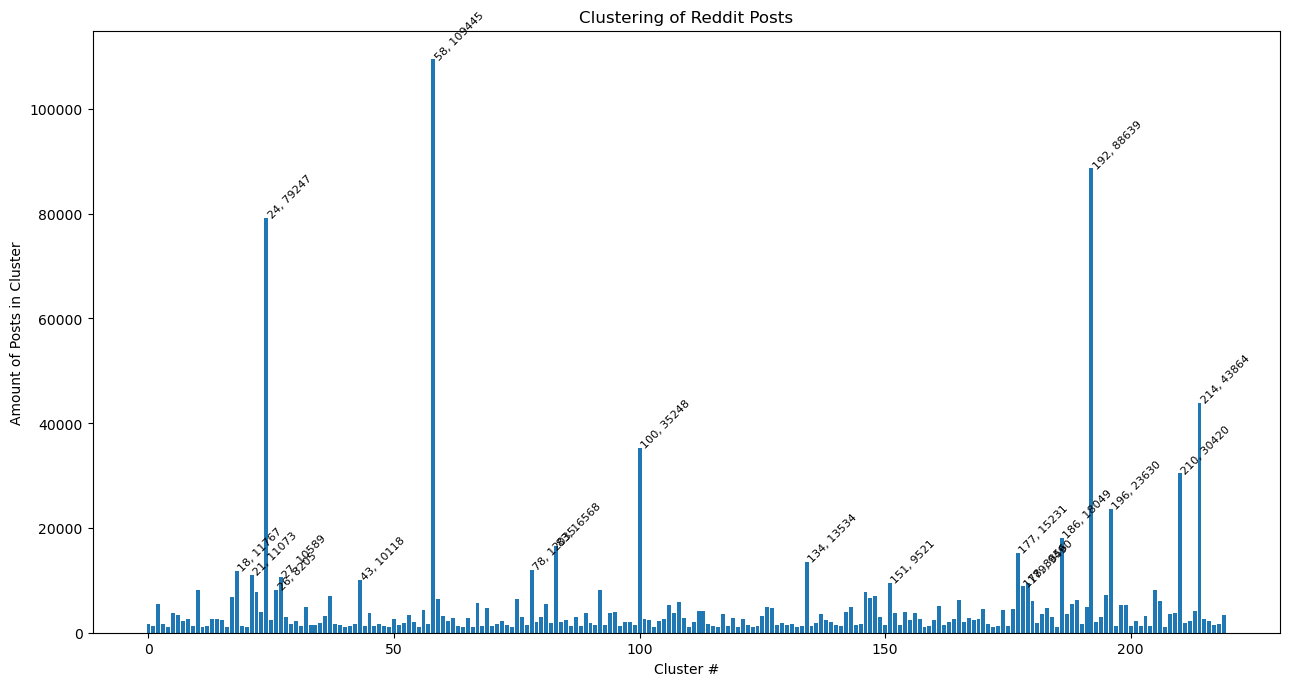

Number of clusters: 220
Outliers: 1193112
Total points: 2312373


In [15]:
# Remove outliers from plot
unique_labels, counts = np.unique(labels_rbf, return_counts=True)
outliers = counts[unique_labels == -1] # Save for statistics
counts = counts[unique_labels != -1]
unique_labels = unique_labels[unique_labels != -1]

plt.figure(figsize=(13, 7))
plt.bar(unique_labels, counts)
plt.xlabel('Cluster #')
plt.ylabel('Amount of Posts in Cluster')
plt.title('Clustering of Reddit Posts')

# Print counts on top of each bar, and cluster name if in top 20

for lab in top_20_labels:
    label_text = f"{lab}, {cluster_sizes[lab]}"
    plt.text(lab, cluster_sizes[lab], label_text, fontsize=8, rotation=45)

plt.tight_layout()

plt.show()

# Print summary statistics
print(f"Number of clusters: {len(unique_labels)}")
print(f"Outliers: {outliers[0]}")
print(f"Total points: {len(labels_rbf)}")

In [16]:
df_clusters.to_csv(data_path + "post_clusters.csv", index=False)

AI assisted plot to visualize the 6 largest clusters of the UMAP projection.

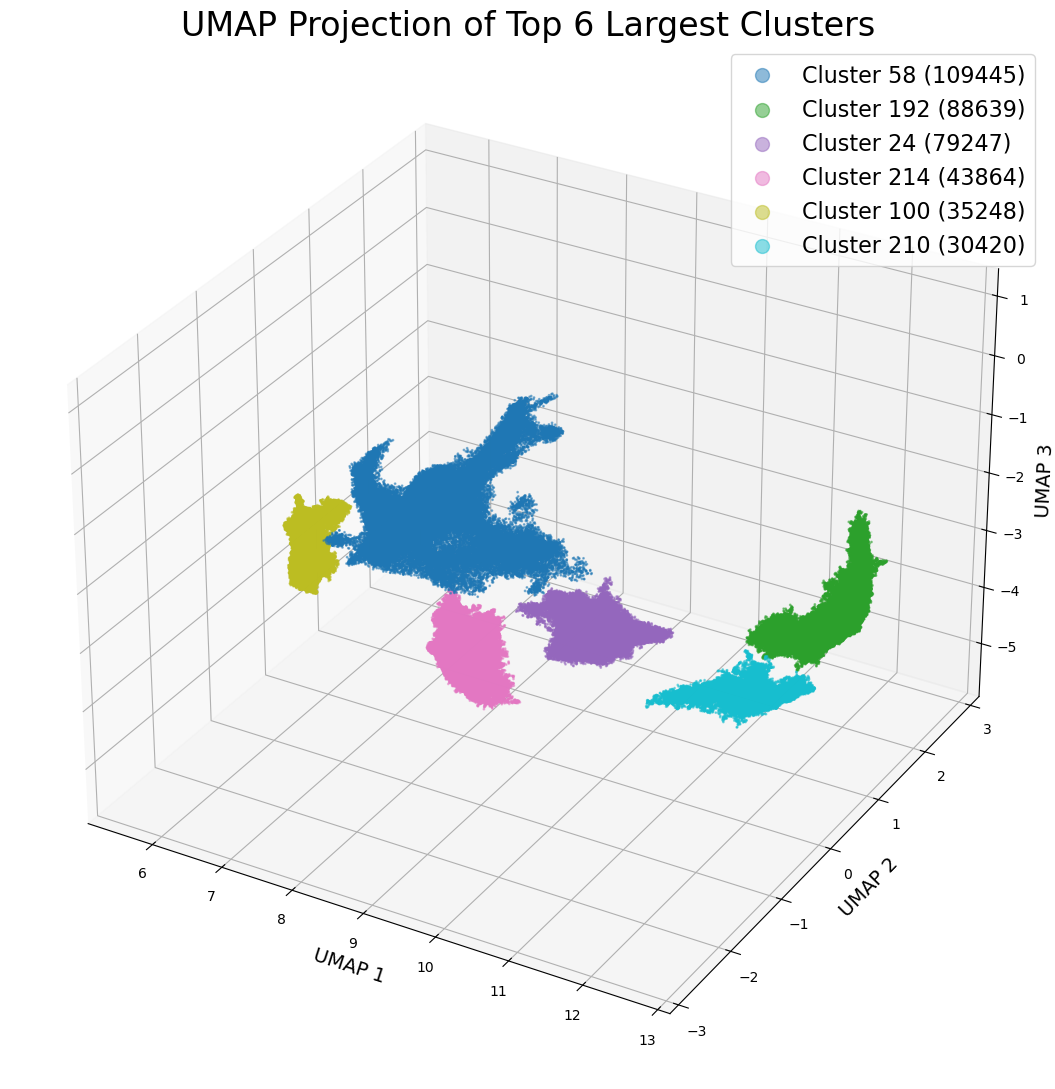

In [26]:
# Get the 6 largest clusters
top_6_labels = cluster_sizes.head(6).index.tolist()

# Filter data for top 6 clusters
mask = np.isin(labels_rbf, top_6_labels)
X_umap_top6 = X_umap[mask]
labels_top6 = labels_rbf[mask]

# Plot
fig = plt.figure(figsize=(12, 11))
ax = fig.add_subplot(111, projection='3d')

# Create colormap
colors = plt.cm.tab10(np.linspace(0, 1, len(top_6_labels)))

for i, label in enumerate(top_6_labels):
    cluster_mask = labels_top6 == label
    ax.scatter(X_umap_top6[cluster_mask, 0], 
               X_umap_top6[cluster_mask, 1], 
               X_umap_top6[cluster_mask, 2],
               c=[colors[i]], 
               label=f'Cluster {label} ({cluster_sizes[label]})',
               alpha=0.5,
               s=1)

ax.set_xlabel('UMAP 1', fontsize=14)
ax.set_ylabel('UMAP 2', fontsize=14)
ax.set_zlabel('UMAP 3', fontsize=14)
ax.set_title('UMAP Projection of Top 6 Largest Clusters', fontsize=24)
ax.legend(loc='upper right', markerscale=10, fontsize=16)
plt.tight_layout()
plt.show()